In [1]:
import io, requests, glob, os, math
import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# Plot a parameter of a dataframe
def plot_param(params, title, data, log=False):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    # Name is the name of the Bundesland. Create a figure for each country.
    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        # Figure order: 0  1
        #               2  3 ...
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        # Draw a line for each parameter
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            if log:
                currentAxis.set_yscale('log')

            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [3]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

# To avoid ssl error (key to short) we use requests.get
req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)

# Read the result in a dataframe
data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

with sqlite3.connect("covid.db") as conn:
    data.to_sql(name='DataRaw', con=conn, if_exists='replace', index=False)
    data = pd.read_sql("""
WITH Analyzed AS (
SELECT
    date(Datum, '-1 day') AS Datum,
    BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung,
    BestaetigteFaelleBundeslaender - LAG(BestaetigteFaelleBundeslaender, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS Neuinfektionen,
    CASE WHEN TestungenPCR - LAG(TestungenPCR, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) > 1000000 THEN NULL ELSE TestungenPCR - LAG(TestungenPCR, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) END AS TestungenPCR,
    Hospitalisierung - LAG(Hospitalisierung, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS HospitalisierungDiff
FROM DataRaw)
SELECT 
    Datum, BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung, HospitalisierungDiff,
    CASE WHEN Neuinfektionen >= 0 THEN Neuinfektionen ELSE NULL END AS Neuinfektionen,
    CASE WHEN TestungenPCR >= 0 THEN TestungenPCR ELSE NULL END AS TestungenPCR,    
    AVG(Neuinfektionen) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Neuinfektionen7DayAvg,
    AVG(Hospitalisierung) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Hospitalisierung7DayAvg,
    AVG(TestungenPCR) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS TestungenPCR7DayAvg
FROM Analyzed;
    """, conn)
    for bl in data["Name"].unique():
        for param in ["TestungenPCR", "HospitalisierungDiff", "Hospitalisierung", "Neuinfektionen"]:
            data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].interpolate(method="linear")
        # Fill na values for first diff.
        data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="bfill")
    data.to_sql(name='DataAnalyzed', con=conn, if_exists='replace', index=False)
    conn.execute("VACUUM")


In [4]:
with sqlite3.connect("covid.db") as conn:
    data = pd.read_sql("SELECT * FROM DataAnalyzed ORDER BY Datum, BundeslandId", conn)
    data["Datum"] = pd.to_datetime(data["Datum"])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)

## Neuinfektionen

Die Neuinfektionen zeigen eine Abhängigkeit vom Wochentag, da am Wochenende weniger getestet wird. Zudem werden die Schultests an bestimmten Tagen durchgeführt.

In [5]:
neuinfektionen = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Neuinfektionen": data.tail(7*10)["Neuinfektionen"],
    }
)
neuinfektionen["NeuinfektionenPrint"] = neuinfektionen.apply(lambda x: f'{x.Neuinfektionen:,.0f}'.replace(",", " "), axis=1)
neuinfektionen.pivot(values="NeuinfektionenPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-03-28,788,1 041,3 881,3 185,1 506,3 166,1 882,1 156,6 225,22 830
2022-03-29,944,1 141,9 097,6 010,2 037,4 537,1 505,1 562,7 910,34 743
2022-03-30,995,1 770,5 285,4 034,1 444,3 631,1 431,1 324,5 979,25 893
2022-03-31,959,1 431,5 725,4 222,1 273,2 175,1 121,902,5 549,23 357
2022-04-01,622,970,4 785,3 327,945,2 288,912,889,4 305,19 043
2022-04-02,330,1 103,2 974,2 222,685,1 461,651,664,3 817,13 907
2022-04-03,577,656,2 886,2 061,519,777,521,895,3 413,12 305


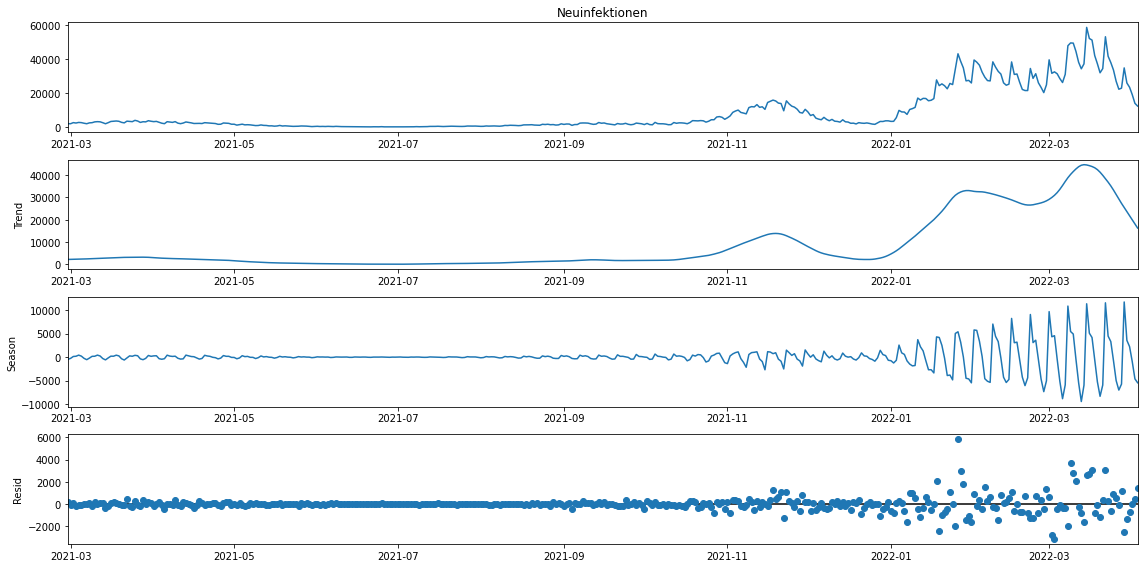

In [6]:
decomposed = STL(data.loc[data["Name"] == "Österreich", "Neuinfektionen"], period=7).fit()
plt.rc("figure", figsize=(16, 8))
decomposed.plot()
plt.show()


### Neuinfektionen (Vorausberechnung)

In [7]:
infektionen = data.loc[data["Name"] == "Österreich", "Neuinfektionen"].tail(15)
fcst = STLForecast(infektionen, ARIMA, period=7, model_kwargs={"order": (2, 1, 0)}).fit().forecast(7)
pd.DataFrame(fcst.apply(lambda x: f'{x:,.0f}'.replace(",", " ")), columns = ["Neuinfektionen"])

C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


,Neuinfektionen
2022-04-04,8 868
2022-04-05,20 778
2022-04-06,11 938
2022-04-07,9 416
2022-04-08,5 126
2022-04-09,20
2022-04-10,-1 521


## Hospitalisierung
### Werte der letzten 7 Tage

In [8]:
hosp = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Hospitalisierung": data.tail(7*10)["Hospitalisierung"],
        "Diff": data.tail(7*10)["HospitalisierungDiff"],
    }
)
hosp["HospitalisierungPrint"] = hosp.apply(lambda x: f'{x.Hospitalisierung:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
hosp.pivot(values="HospitalisierungPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-03-28,139 (14),262 (-9),700 (16),464 (-16),120 (10),571 (29),231 (6),116 (9),730 (15),3 333 (74)
2022-03-29,144 (5),244 (-18),709 (9),451 (-13),112 (-8),552 (-19),215 (-16),115 (-1),759 (29),3 301 (-32)
2022-03-30,143 (-1),228 (-16),676 (-33),447 (-4),105 (-7),514 (-38),204 (-11),116 (1),753 (-6),3 186 (-115)
2022-03-31,149 (6),194 (-34),663 (-13),407 (-40),101 (-4),518 (4),190 (-14),112 (-4),735 (-18),3 069 (-117)
2022-04-01,150 (1),192 (-2),667 (4),407 (0),107 (6),526 (8),202 (12),112 (0),724 (-11),3 087 (18)
2022-04-02,150 (0),206 (14),639 (-28),407 (0),107 (0),526 (0),202 (0),112 (0),705 (-19),3 054 (-33)
2022-04-03,150 (0),209 (3),643 (4),367 (-40),107 (0),526 (0),202 (0),100 (-12),666 (-39),2 970 (-84)


### Diagramm

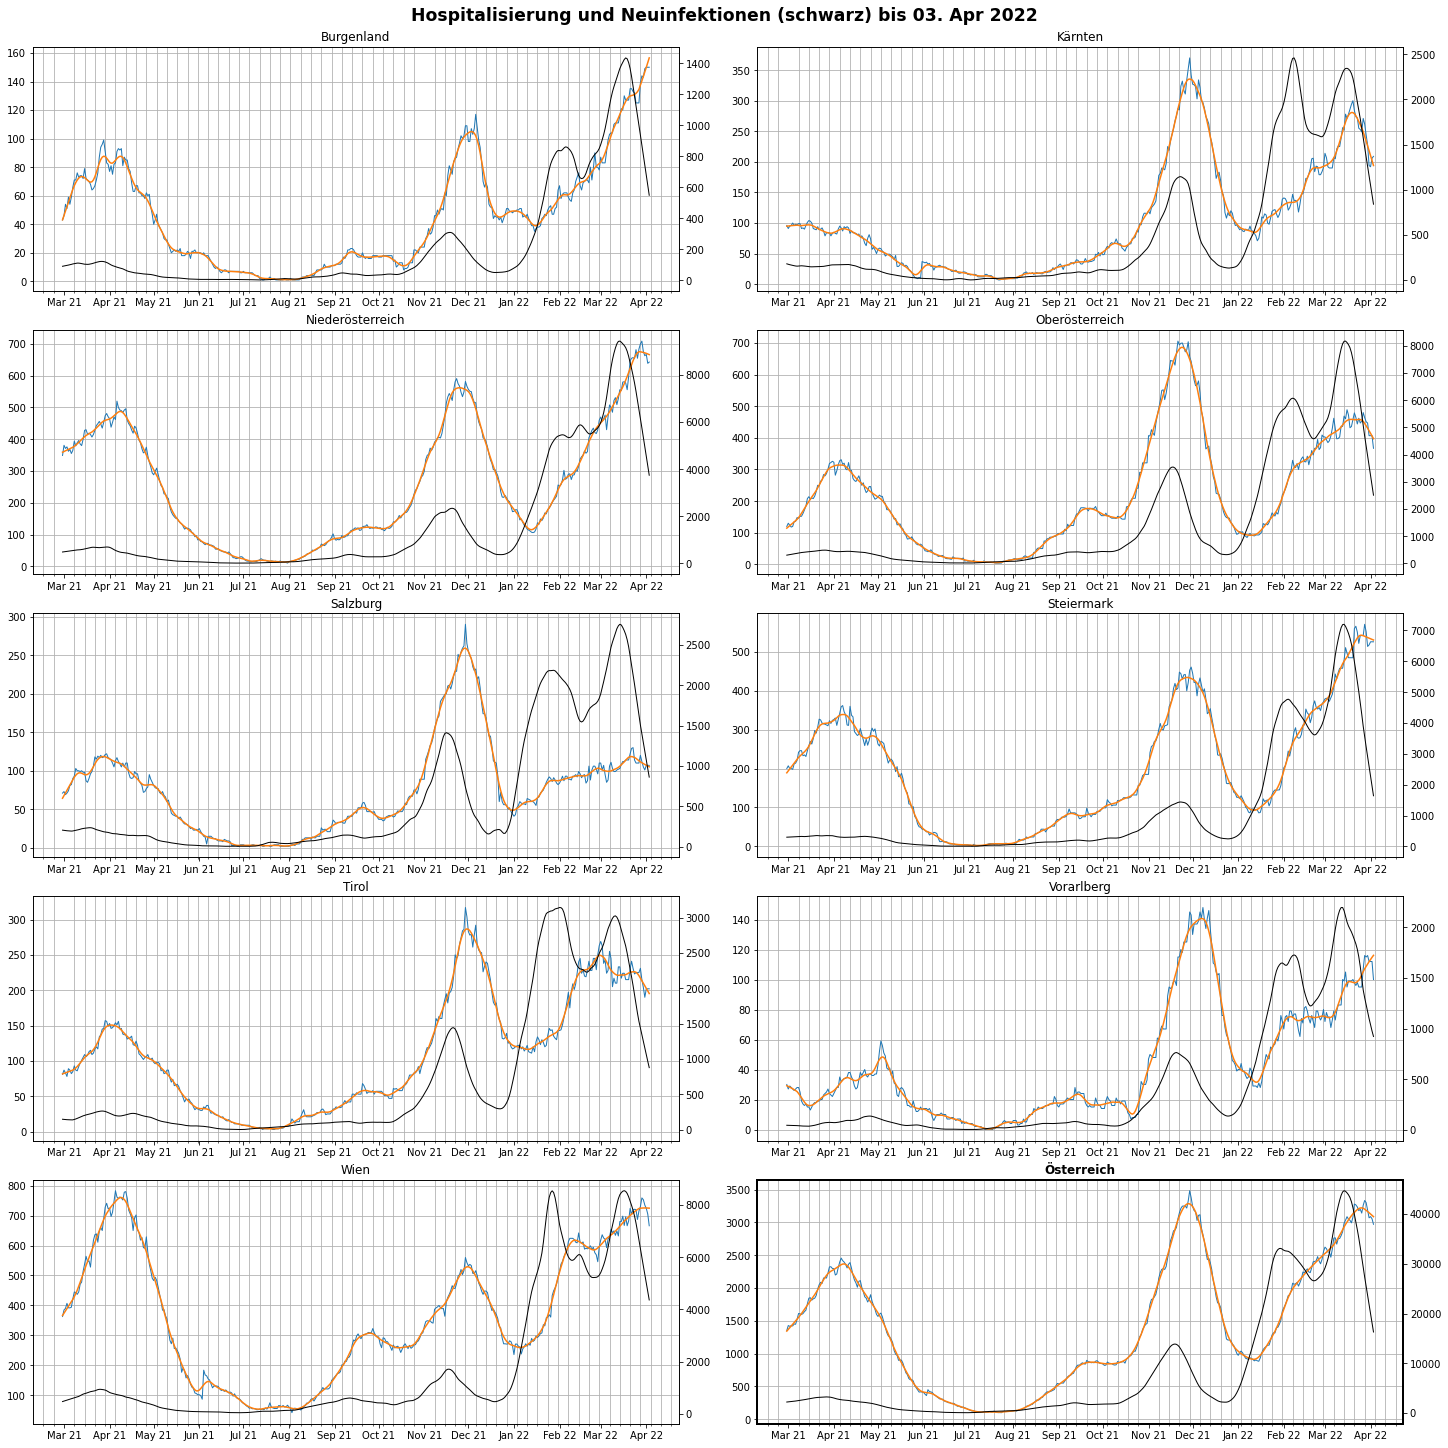

In [9]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


### Logarithmischer Plot

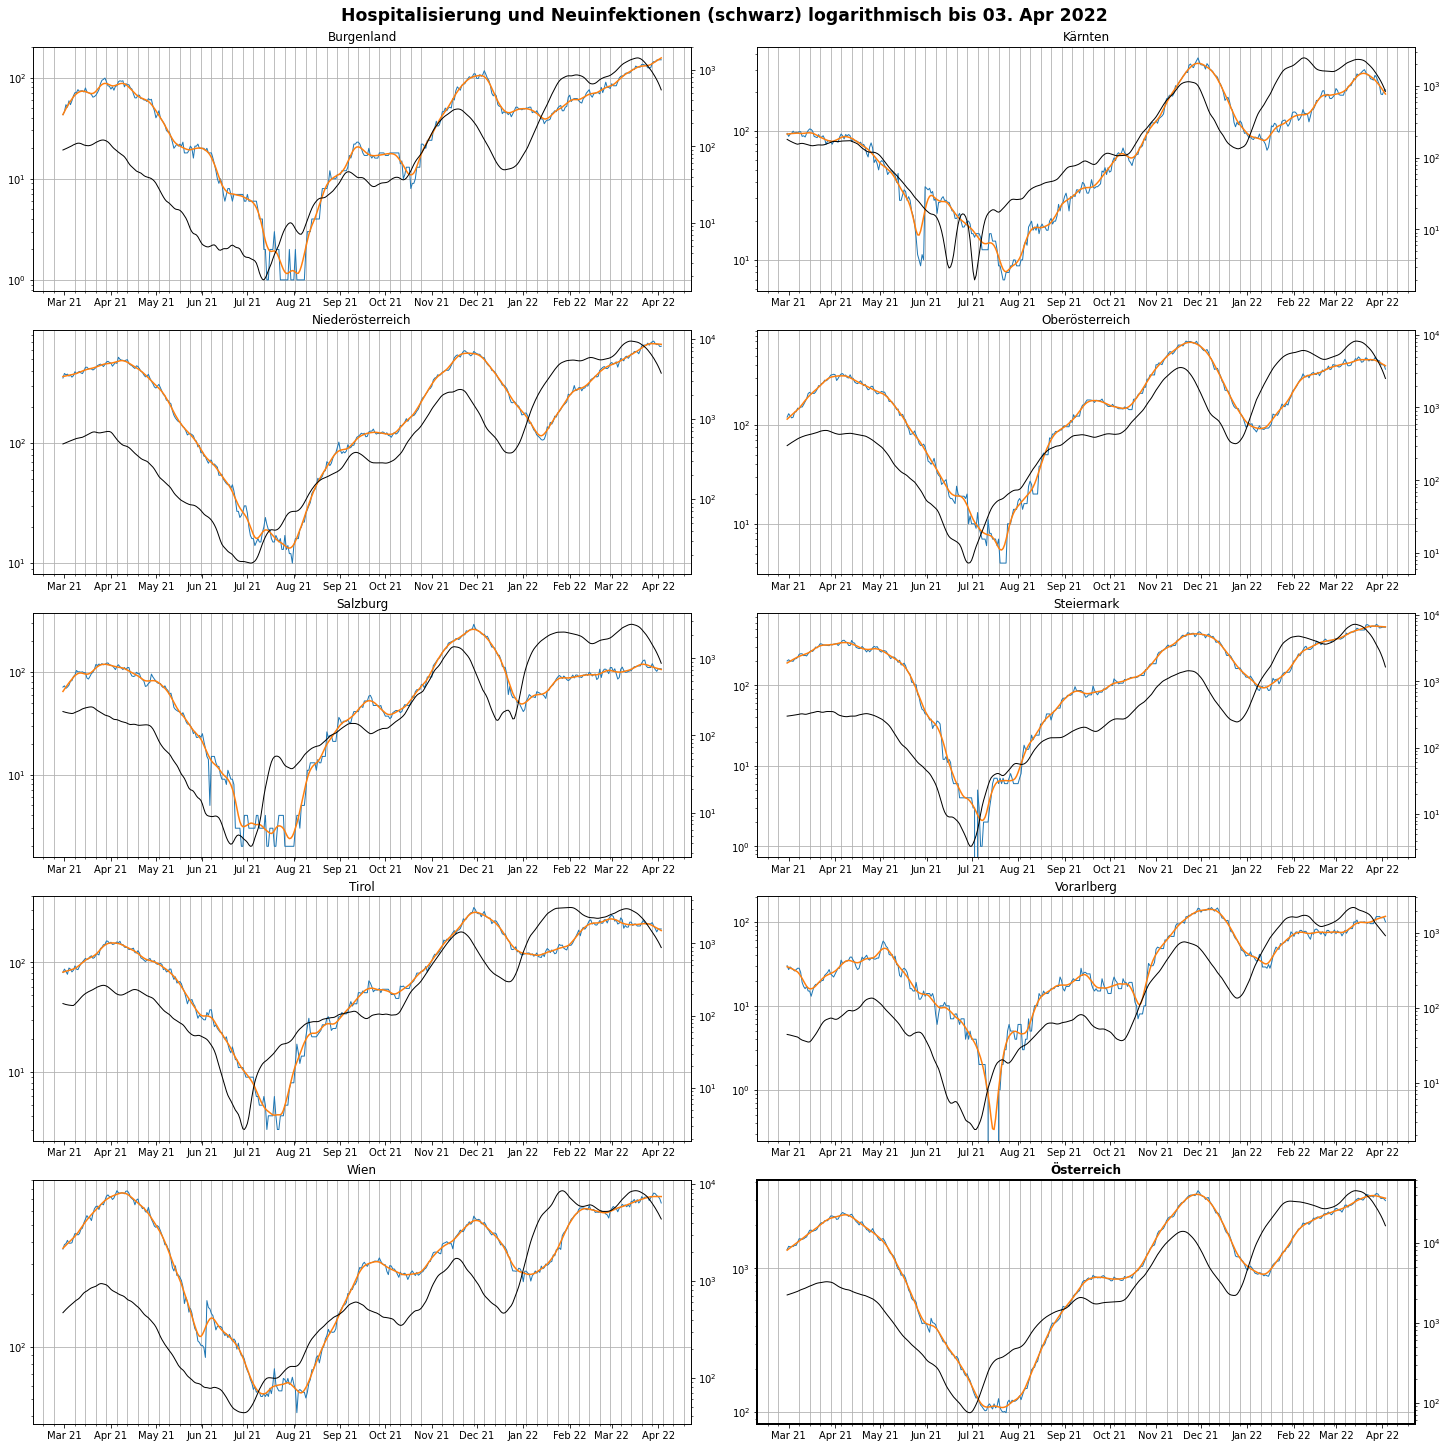

In [10]:
plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz) logarithmisch", data, log=True)

## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [11]:
pcrTaeglich = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "TestungenPCR": data.tail(7*10)["TestungenPCR"],
        "Diff": data.tail(8*10)["TestungenPCR"].diff(periods=10).tail(7*10)
    }
)
pcrTaeglich["TestungenPrint"] = pcrTaeglich.apply(lambda x: f'{x.TestungenPCR:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
pcrTaeglich.pivot(values="TestungenPrint", columns="Name")

Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-03-28,6 367 (-568),4 056 (1 054),31 888 (5 085),15 851 (-757),7 380 (2 642),14 148 (2 559),12 154 (5 300),5 105 (-24),265 319 (140 012),362 268 (155 303)
2022-03-29,7 495 (1 128),3 442 (-614),334 004 (302 116),14 062 (-1 789),9 293 (1 913),14 898 (750),9 874 (-2 280),5 167 (62),212 725 (-52 594),610 960 (248 692)
2022-03-30,7 286 (-209),2 110 (-1 332),29 462 (-304 542),9 974 (-4 088),6 929 (-2 364),15 844 (946),8 873 (-1 001),4 499 (-668),231 523 (18 798),316 500 (-294 460)
2022-03-31,7 195 (-91),4 038 (1 928),23 368 (-6 094),11 405 (1 431),7 156 (227),8 743 (-7 101),8 864 (-9),3 754 (-745),220 902 (-10 621),295 425 (-21 075)
2022-04-01,8 299 (1 104),3 378 (-660),226 501 (203 133),12 566 (1 161),5 219 (-1 937),8 387 (-356),6 585 (-2 279),2 717 (-1 037),167 660 (-53 242),441 312 (145 887)
2022-04-02,3 653 (-4 646),2 014 (-1 364),28 249 (-198 252),12 165 (-401),3 664 (-1 555),1 379 (-7 008),5 994 (-591),2 769 (52),130 992 (-36 668),190 879 (-250 433)
2022-04-03,2 543 (-1 110),2 104 (90),21 040 (-7 209),8 269 (-3 896),2 350 (-1 314),3 016 (1 637),3 813 (-2 181),2 884 (115),125 940 (-5 052),171 959 (-18 920)


### Diagramm

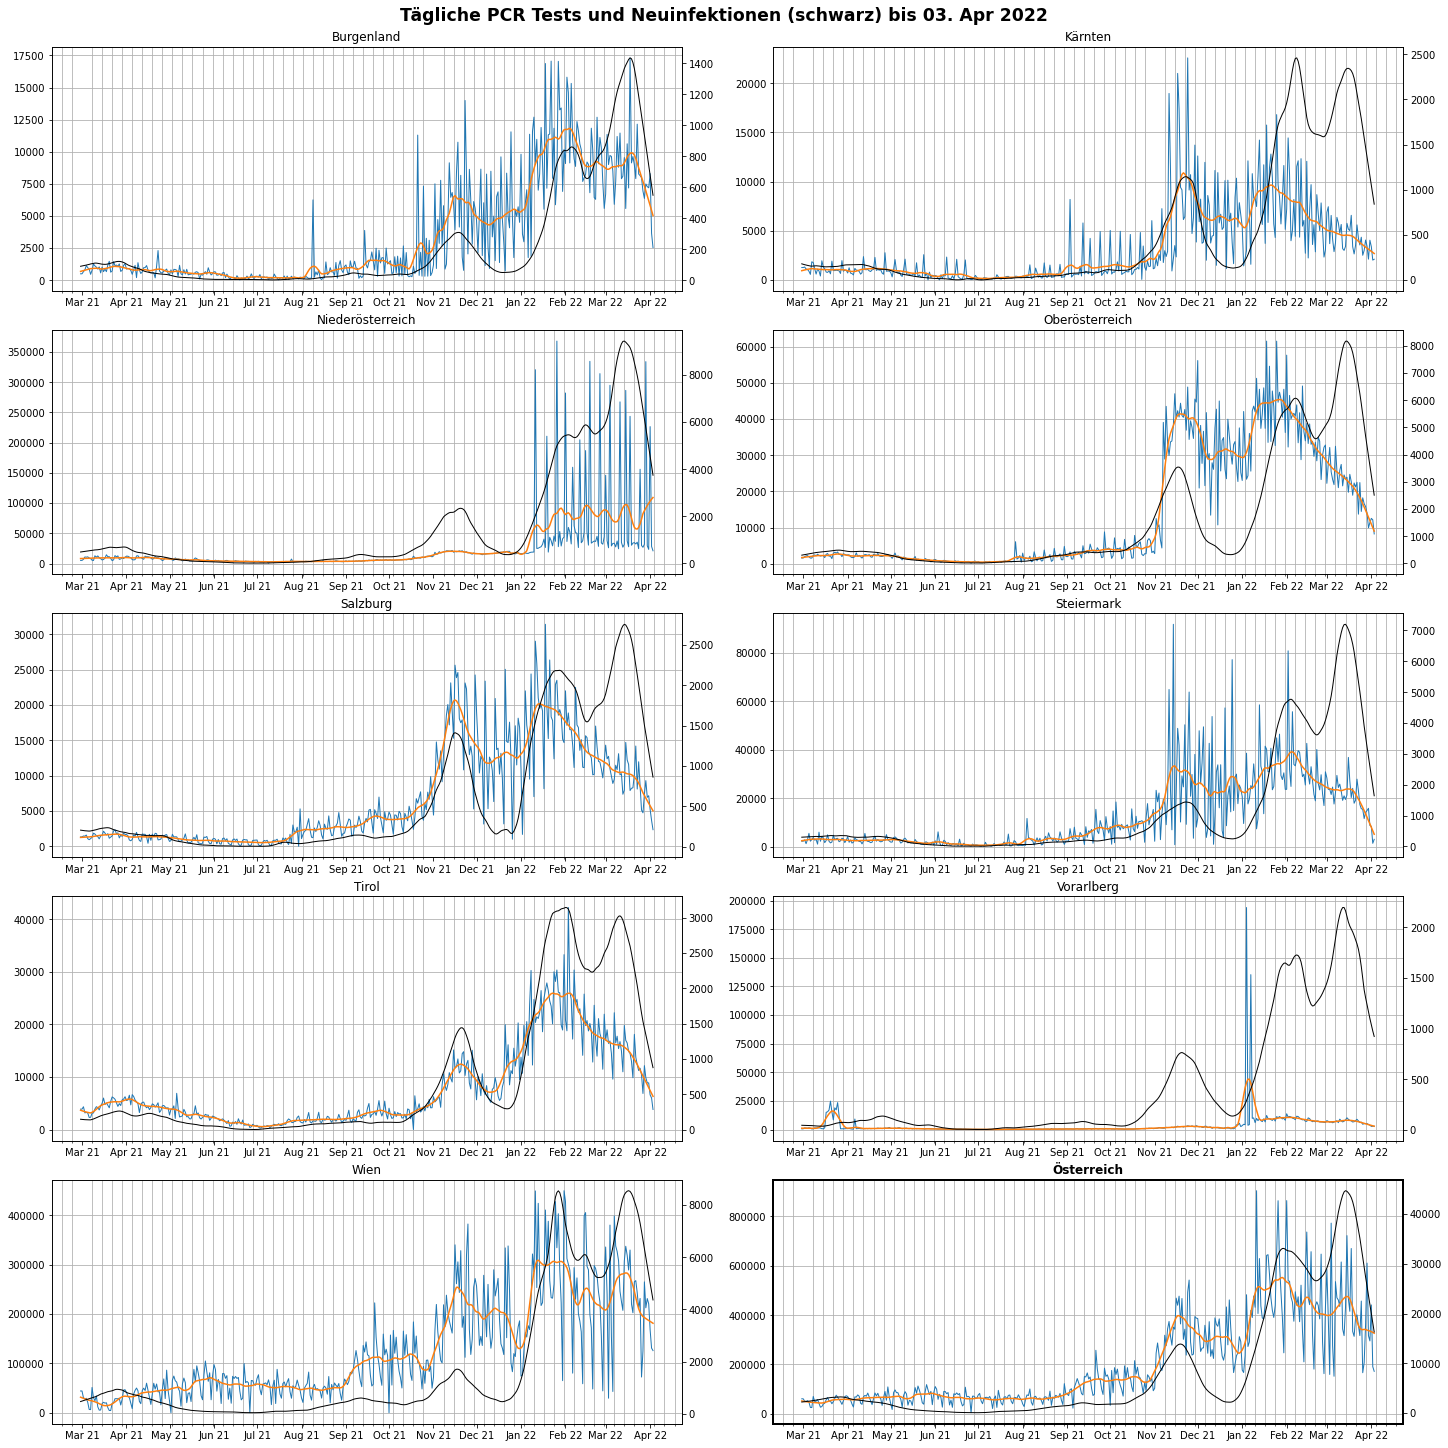

In [12]:
plot_param(["TestungenPCR", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (schwarz)", data)